## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import numpy.random as rnd
#rnd.seed(42)

In [3]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin

## Classes

### Feature Adder

In [4]:
class FeaturesAdder(BaseEstimator,TransformerMixin):
    """This class adds new features in the dataset.
        Features added are : rooms_per_household, bedrooms_per_room, and population_per_household.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X['rooms_per_household']=X['total_rooms']/X['households']
        X['bedrooms_per_room']=X['total_bedrooms']/X['total_rooms']
        X['population_per_household']=X['population']/X['households']
        return X

### Removing Outliers

In [5]:
class RemoveOutliers(BaseEstimator,TransformerMixin):
    """This class removes outliers from data.
    Note: Outlier values are hard coded
    """
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X=X[(X['median_house_value']!=500001) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[X['median_income']<=11].reset_index(drop=True)
        X=X[(X['median_house_value']!=350000) | (X['median_income']>=1.5)].reset_index(drop=True)
        X=X[(X['median_house_value']!=450000) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[(X['median_house_value']>=350000) | (X['median_income']<=9.5)].reset_index(drop=True)
        X=X[X['population']<=9000]
        X=X[(X['population_per_household']>=1.15) & (X['population_per_household']<=6.5)]
        X=X[X['rooms_per_household']<20]
        X=X[X['bedrooms_per_room']<0.5].reset_index(drop=True)
        return X

### Features transformer

In [6]:
class FeaturesTransformer(BaseEstimator,TransformerMixin):
    """This class trnsforms numberical featuress in the dataset.
    Note: Transformations are hard coded.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        import numpy as np
        from scipy.special import boxcox1p        
        X['total_rooms']=X['total_rooms'].apply(lambda x: boxcox1p(x,0.25))
        X['total_bedrooms']=X['total_bedrooms'].apply(lambda x: boxcox1p(x,0.25))
        X['households']=X['households'].apply(lambda x: boxcox1p(x,0.2))
        X['population']=X['population'].apply(lambda x: boxcox1p(x,0.3))
        X['rooms_per_household']=X['rooms_per_household'].apply(lambda x: np.log1p(x)**0.5)
        X['bedrooms_per_room']=X['bedrooms_per_room'].apply(lambda x: np.log1p(x)**0.25)
        X['median_income']=X['median_income'].apply(lambda x: np.log1p(x)**1.25)
        X['population_per_household']=X['population_per_household'].apply(lambda x: np.log1p(x)**1)
        return X

### DataFrame Selector

In [8]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    """This class is a dataframe selector.
        Data members:
            features: A list of column_names you want in output dataframe
    """
    def __init__(self,features):
        self.features=features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.features]

### Get Dummies

In [9]:
class GetDummies(BaseEstimator,TransformerMixin):
    """This class is used to get dummy columns from categorical columns."""
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        #change ISLAND to NEAR BAY...as count of ISLAND is very low
        X[X=='ISLAND']='NEAR BAY'
        return (pd.get_dummies(X,drop_first=True))

### Removing Values

In [10]:
def remove_by_pvalue(X,y,pvalue=0.05):
    """Remove features with p-value more than 'pvalue'
    
    This function uses statsmodels.api.OLS model. Please add intercept to data externally.
    Input:
        X: Array or dataframe excluding predicted variable
        y: Series or list of predicted variable
        pvalue: int or float
    
    Note:
        X is changed inplace
    """
    import statsmodels.api as sm
    for i in range(len(X.columns)):
        regressor_OLS=sm.OLS(endog=y,exog=X).fit()
        s=regressor_OLS.pvalues.sort_values(ascending=False)
        if s.iloc[0]>pvalue:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],'P-value: ',s.iloc[0])
        
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],', VIF: ',s.iloc[0])
        else:
            break

## Preparing Data

### Import Data from CSV

In [11]:
housing_data = pd.read_csv('C:/Users/kalam/OneDrive - Adobe/Personal/Data Sceince/dataset for students.csv')
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18565.000000,18565.000000,18565.000000,18565.000000,18376.000000,18565.000000,18565.000000,18565.000000,18565.000000
mean,-119.570116,35.633888,28.615890,2634.033827,537.711199,1426.223108,499.450902,3.867012,206617.794991
std,2.002922,2.137014,12.564224,2195.915548,424.125849,1142.570832,384.553175,1.895988,115447.104881
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1442.000000,295.000000,786.000000,279.000000,2.561200,119300.000000
50%,-118.500000,34.260000,29.000000,2123.000000,434.000000,1166.000000,408.000000,3.534100,179400.000000
75%,-118.010000,37.710000,37.000000,3141.000000,646.000000,1725.000000,603.000000,4.741100,264400.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Data Correlation

In [12]:
housing_data.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924545,-0.107575,0.043183,0.067712,0.097420,0.053778,-0.013332,-0.045035
latitude,-0.924545,1.000000,0.011147,-0.035373,-0.065896,-0.106982,-0.070205,-0.081693,-0.145263
housing_median_age,-0.107575,0.011147,1.000000,-0.359676,-0.320041,-0.294054,-0.302620,-0.121457,0.103826
total_rooms,0.043183,-0.035373,-0.359676,1.000000,0.930809,0.855342,0.918620,0.200269,0.134641
total_bedrooms,0.067712,-0.065896,-0.320041,0.930809,1.000000,0.876034,0.979671,-0.003778,0.050108
population,0.097420,-0.106982,-0.294054,0.855342,0.876034,1.000000,0.905547,0.007324,-0.023836
households,0.053778,-0.070205,-0.302620,0.918620,0.979671,0.905547,1.000000,0.016365,0.066069
median_income,-0.013332,-0.081693,-0.121457,0.200269,-0.003778,0.007324,0.016365,1.000000,0.688783
median_house_value,-0.045035,-0.145263,0.103826,0.134641,0.050108,-0.023836,0.066069,0.688783,1.000000


### Scatter Graph 

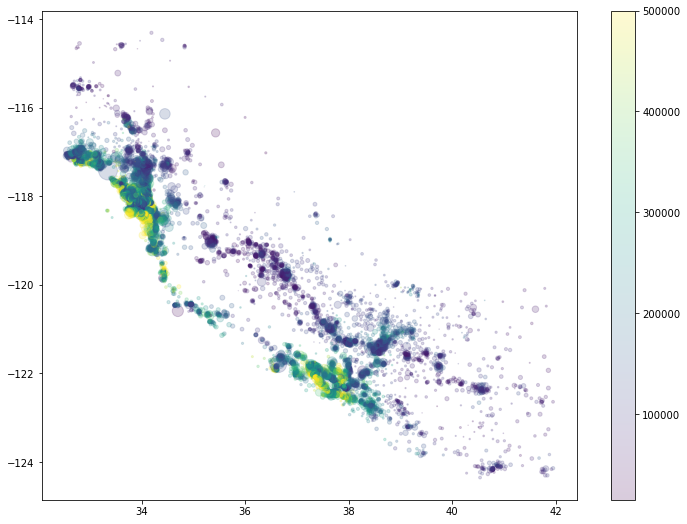

In [13]:
plt.figure(figsize = (12, 9))
plt.scatter(housing_data.latitude, housing_data.longitude, alpha = 0.2, c = housing_data.median_house_value, s = housing_data.population/100)
plt.colorbar()

In [14]:
#Adding features
housing_data=FeaturesAdder().fit_transform(housing_data)

num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

#Removing outliers
housing_data=RemoveOutliers().fit_transform(housing_data)

data_labels=housing_data['median_house_value']
housing_data=housing_data.drop('median_house_value',axis=1)

#Transforming features
housing_data=FeaturesTransformer().fit_transform(housing_data)

num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household','bedrooms_per_room', 'population_per_household']
cat_featues=['ocean_proximity']

#Mean value imputation, feature scaling, gettin gdummy variables
num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_features)),
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler())
])

cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_featues)),
    ('get_dummies',GetDummies())
])

#Combining numerical and categorica data
data_cleaning_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),  
])


housing_data=data_cleaning_pipeline.fit_transform(housing_data)
l=num_features.copy()
l.extend([0,1,2])
housing_data=pd.DataFrame(housing_data,columns=l)

#Check for multicoliniearity
remove_by_vif(housing_data)
remove_by_pvalue(housing_data,data_labels)

data_prepared=housing_data
y_train=data_labels.copy()

label_scaler=StandardScaler()
data_labels=label_scaler.fit_transform(y_train.values.reshape(-1,1))

C:\Users\kalam\AppData\Local\Temp/ipykernel_42884/3697010208.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X=='ISLAND']='NEAR BAY'
C:\Users\kalam\Anaconda3\lib\site-packages\pandas\core\frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


Removed:  total_bedrooms , VIF:  525.7709324444197
Removed:  households , VIF:  227.54268512427845
Removed:  total_rooms , VIF:  105.42143924591775
Removed:  latitude , VIF:  18.108383417056906
Removed:  bedrooms_per_room , VIF:  5.548320339249713


In [15]:

data_prepared.info()
housing_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17987 entries, 0 to 17986
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17987 non-null  float64
 1   housing_median_age        17987 non-null  float64
 2   population                17987 non-null  float64
 3   median_income             17987 non-null  float64
 4   rooms_per_household       17987 non-null  float64
 5   population_per_household  17987 non-null  float64
 6   0                         17987 non-null  float64
 7   1                         17987 non-null  float64
 8   2                         17987 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


,longitude,housing_median_age,population,median_income,rooms_per_household,population_per_household,0,1,2
0,-1.324052,0.989411,-1.642152,2.193690,1.238275,-0.435349,0.0,1.0,0.0
1,-1.319066,-0.610342,1.133259,2.185460,0.780698,-1.176658,0.0,1.0,0.0
2,-1.334022,1.869275,-1.026070,0.169138,0.809110,-1.050630,0.0,1.0,0.0
3,-1.334022,1.869275,-1.382279,0.283421,-0.329515,-1.123426,0.0,1.0,0.0
4,-1.334022,1.869275,-0.155231,0.053214,-0.183932,-1.143719,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
17982,-0.755722,-0.290392,-0.516337,-1.608358,-0.089779,-0.427492,1.0,0.0,0.0
17983,-0.815546,-0.850305,-1.539690,-0.720911,0.698858,0.383908,1.0,0.0,0.0
17984,-0.820531,-0.930293,-0.274165,-1.469543,0.039194,-0.805344,1.0,0.0,0.0
17985,-0.870385,-0.850305,-0.689492,-1.310303,0.136191,-1.152919,1.0,0.0,0.0


## Choosing Machine Learning Algorithm

In [16]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split
from sklearn.model_selection import GridSearchCV

In [17]:
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plots validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]
    
    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()

### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression,Ridge

lr=LinearRegression()
scores=cross_val_score(lr,data_prepared,data_labels,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.7256080717653138


In [19]:
lr=LinearRegression()
scores=cross_val_score(lr,data_prepared,y_train,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  74212.34807967233


### Ridge Regression

In [65]:
ridge=Ridge(alpha=0.1,random_state=42)
scores=cross_val_score(ridge,data_prepared,data_labels,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.7256120011574305


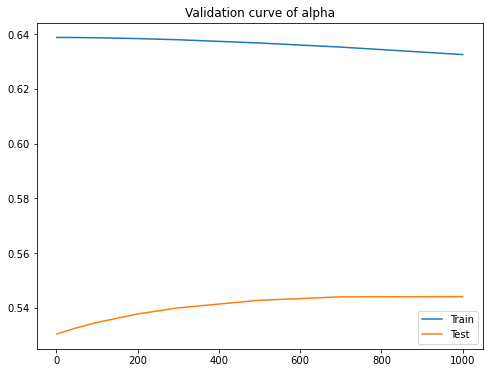

In [63]:
ridge=Ridge(random_state=42)
param_name='alpha'
param_range = [1,10,50,100,200,300,500,700,1000]
#param_range=[1,10,100,800,900,1000,1200,1400,1600,1800,2000]
scoring='r2'
#scoring='neg_mean_squared_error'
curve=validation_curve(ridge,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)

n=len(param_range)
'''
if scoring=='r2':
    train_score=[curve[0][i].mean() for i in range (0,n)]
    test_score=[curve[1][i].mean() for i in range (0,n)]
elif scoring=='neg_mean_squared_error':
    train_score=[np.sqrt(-curve[0][i].mean()) for i in range (0,n)]
    test_score=[np.sqrt(-curve[1][i].mean()) for i in range (0,n)]
'''

plot_validation_curve(curve,param_range,param_name,scoring)

### Support Vector Regression

In [54]:
from sklearn.svm import SVR

svr=SVR(degree=2)
param_grid={
    'C':[1,10,50,100]
}
scoring='r2'
grid=GridSearchCV(svr,param_grid,scoring=scoring,n_jobs=-1,cv=3,verbose=3)
grid.fit(data_prepared,data_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\kalam\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=3, estimator=SVR(degree=2), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100]}, scoring='r2', verbose=3)

In [73]:
print(grid.best_params_)
print("----------------")
print(grid.best_score_)

{'C': 1}
----------------
0.66143457838841


In [66]:
svr=SVR(kernel='rbf',C=100)
scores=cross_val_score(svr,data_prepared,data_labels,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())
print('RMSE: ',np.sqrt(-scores).mean())

R2:  0.7426444827884275
RMSE:  nan


C:\Users\kalam\AppData\Local\Temp/ipykernel_8656/2908330282.py:4: RuntimeWarning: invalid value encountered in sqrt
  print('RMSE: ',np.sqrt(-scores).mean())


### Decision Tress

In [20]:
from sklearn.tree import DecisionTreeRegressor

dtr=DecisionTreeRegressor(random_state=42)
scores=cross_val_score(dtr,data_prepared,y_train,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.5889188779090204


#### Max Depth

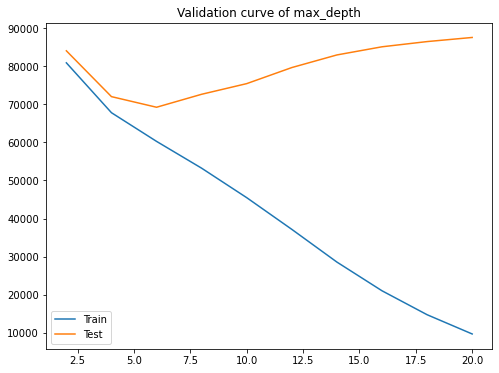

In [21]:
dtr=DecisionTreeRegressor(random_state=42)
param_name='max_depth'
param_range = range(2,21,2)
scoring='neg_mean_squared_error'
curve=validation_curve(dtr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)

plot_validation_curve(curve,param_range,param_name,scoring)

#### Max Features

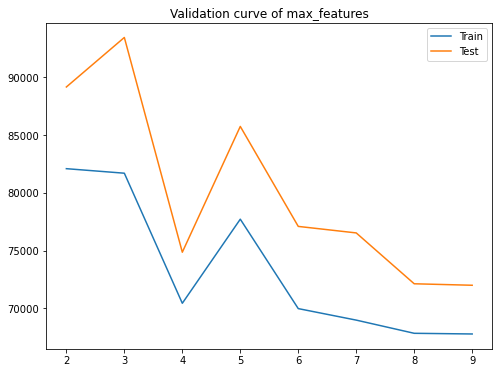

In [22]:
dtr=DecisionTreeRegressor(max_depth=4,random_state=42)
param_name='max_features'
param_range = range(2,10)
scoring='neg_mean_squared_error'
curve=validation_curve(dtr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)
plot_validation_curve(curve,param_range,param_name,scoring)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbr=GradientBoostingRegressor(random_state=42)
param_grid={
    'n_estimators':[100,500,1000],
    'max_depth':range(3,9,1),
    'max_features':[6,7,9],
    'min_samples_split':[200,400]  
}
scoring='r2'
grid=GridSearchCV(gbr,param_grid,scoring=scoring,n_jobs=-1,cv=3,verbose=1)
grid.fit(data_prepared,y_train)
print(grid.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'max_depth': 5, 'max_features': 6, 'min_samples_split': 200, 'n_estimators': 100}


In [25]:
## To be added

In [27]:
gbr=GradientBoostingRegressor(max_depth = 5, max_features=6, min_samples_split=200, n_estimators=100,random_state=42)
scores=cross_val_score(gbr,data_prepared,y_train,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.8202485673130188


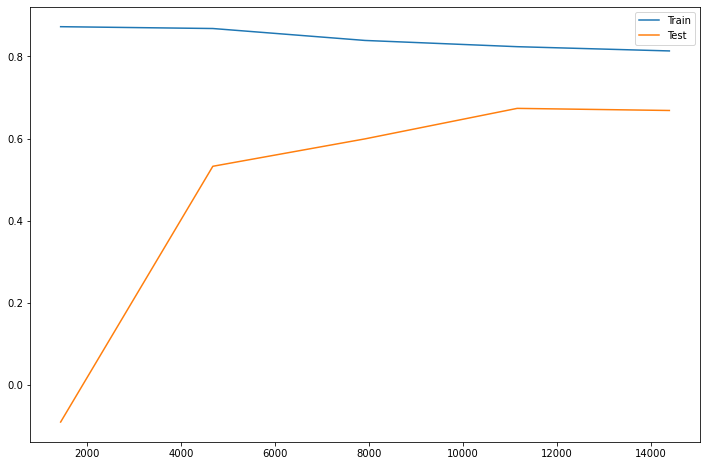

In [33]:
gbr=GradientBoostingRegressor(max_depth= 5, max_features=6, min_samples_split=200, n_estimators=100,random_state=42)
lc=learning_curve(gbr,data_prepared,y_train,cv=5,n_jobs=-1)
size=lc[0]
train_score=[lc[1][i].mean() for i in range (0,5)]
test_score=[lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(12,8))
plt.plot(size,train_score,label='Train')
plt.plot(size,test_score,label="Test")
plt.legend()



In [34]:
scores=cross_val_score(gbr,data_prepared,y_train,n_jobs=-1,cv=3,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.8355689604945423


In [35]:
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  nan


C:\Users\kalam\AppData\Local\Temp/ipykernel_42884/2674860680.py:1: RuntimeWarning: invalid value encountered in sqrt
  print('RMSE: ',np.sqrt(-scores).mean())
